In [26]:
from langgraph.graph import StateGraph
from langchain_community.tools import Tool
from langchain.tools import tool
from langchain.agents import create_structured_chat_agent
from langchain_core.messages import HumanMessage
import pandas as pd
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.chat_models import ChatDeepInfra
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor


In [31]:
def load_data(file_path: str) -> pd.DataFrame:
    """Load CSV file into DataFrame with timestamp handling"""
    return pd.read_csv(file_path, parse_dates=True, index_col=0)

@tool
def analyze_missing_values(df: pd.DataFrame) -> dict:
    """Analyze missing values pattern in time series data"""
    analysis = {
        "total_missing": df.isna().sum().sum(),
        "columns_with_missing": df.columns[df.isna().any()].tolist(),
        "time_gaps": pd.to_datetime(df.index).to_series().diff().value_counts().to_dict()
    }
    return analysis

@tool
def suggest_preprocessing(df: pd.DataFrame) -> str:
    """Suggest preprocessing steps based on data characteristics"""
    suggestions = []
    
    if df.isna().sum().sum() > 0:
        suggestions.append("Missing value imputation (time-aware)")
    
    if not df.index.is_monotonic_increasing:
        suggestions.append("Time index sorting")
    
    if len(df.index.normalize().unique()) != len(df.index):
        suggestions.append("Resampling to regular frequency")
    
    return ", ".join(suggestions) if suggestions else "No preprocessing needed"

@tool
def execute_preprocessing(df: pd.DataFrame, operations: list) -> pd.DataFrame:
    """Execute preprocessing pipeline"""
    result = df.copy()
    
    for op in operations:
        if "imputation" in op.lower():
            result = result.interpolate(method='time')
        elif "sorting" in op.lower():
            result = result.sort_index()
        elif "resampling" in op.lower():
            result = result.resample('1H').mean()  # Default hourly resample
    
    return result

# print(execute_preprocessing.name)
# print(execute_preprocessing.description)
# print(execute_preprocessing.args)

In [38]:
from typing_extensions import TypedDict

class State(TypedDict):
    messages: list
    logs: list
    all_tool_outputs: list

# graph_builder = StateGraph(State)

def build_preprocessing_agent(llm):
    # Define tools with proper names and descriptions
    tools = [
        Tool(
            name="data_loader",
            description="Loads time series data from CSV file. Input: file path. Output: Pandas DataFrame.",
            func=load_data
        ),
        Tool(
            name="missing_value_analyzer",
            description="Analyzes missing values in time series data. Input: DataFrame. Output: Analysis dictionary.",
            func=analyze_missing_values
        ),
        Tool(
            name="preprocessing_advisor",
            description="Suggests appropriate preprocessing steps for time series data. Input: DataFrame. Output: Comma-separated suggestions.",
            func=suggest_preprocessing
        ),
        Tool(
            name="preprocessing_executor",
            description="Executes preprocessing operations on time series data. Input: (DataFrame, operations_list). Output: Transformed DataFrame.",
            func=execute_preprocessing
        )
    ]
    
    # Create proper prompt template
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a time series preprocessing expert. Follow these steps:
        1. Load the data (ensure proper timestamp handling)
        2. Analyze data quality (missing values, time gaps)
        3. Recommend preprocessing steps
        4. Execute transformations
        5. Validate results
        
        Always maintain the time series characteristics during processing.
        
        Tools available: {tools}, {tool_names}
        """),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ])
    
    # Create agent with proper memory handling
    agent = create_structured_chat_agent(
        llm=llm,
        tools=tools,
        prompt=prompt
    )
    
    # Create executor with proper settings
    agent_executor = AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=True,
        handle_parsing_errors=True,
        max_iterations=10
    )
    # Build workflow graph
    workflow = StateGraph(State)
    
    # Define nodes with proper state handling
    workflow.add_node("load", lambda state: {"df": tools[0].run(state["file_path"])})
    workflow.add_node("analyze", lambda state: {"analysis": tools[1].run(state["df"])})
    workflow.add_node("suggest", lambda state: {"suggestions": tools[2].run(state["df"]).split(", ")})
    workflow.add_node("execute", lambda state: {"processed_df": tools[3].run({"df": state["df"], "operations": state["suggestions"]})})
    
    # Connect nodes
    workflow.add_edge("load", "analyze")
    workflow.add_edge("analyze", "suggest")
    workflow.add_edge("suggest", "execute")
    
    workflow.set_entry_point("load")
    workflow.set_finish_point("execute")


    checkpointer = MemorySaver()
    config = {
        "configurable": {
            "model": llm,
            "thread_id": "1"
        }
    }
    graph = workflow.compile(checkpointer=checkpointer)
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
    
    return workflow.compile()

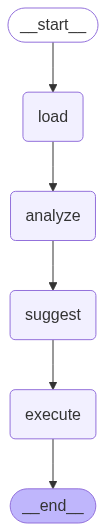

In [39]:
# Initialize
llm = ChatDeepInfra(
    model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
    temperature=0
)
preprocessor = build_preprocessing_agent(llm)

# # Run pipeline
# result = preprocessor.invoke({
#     "file_path": "timeseries_data.csv",
#     "chat_history": []
# })

# # Get processed data

# processed_df = result["execute"]